In [ ]:
import sys, os
import shutil
os.chdir("/home/shared")

# clear RBniCS cache
RBNICS_CACHE = "/home/shared/Subfin_NO_GEOMETRY_PARAM"
if os.path.exists(RBNICS_CACHE):
    shutil.rmtree(RBNICS_CACHE)

sys.path.append("./src")
sys.path.append("./src/kriging")
from dolfin import *
from rbnics import *

In [24]:
import time
import numpy as np
import matplotlib.pyplot as plt
import importlib
import inverse_id
importlib.reload(inverse_id)
from inverse_id import sensor_output, plot_sensor, identify, read_sensor, monitor, control_cooling

# Define finite element (FE) model
We consider a steady-state heat transfer problem on a thermal fin using an FE method. The thermal fin model is from RBniCS tutorial (https://colab.research.google.com/github/RBniCS/RBniCS/blob/open-in-colab/tutorials/21_thermal_subfin/tutorial_thermal_subfin.ipynb) and we modify the model such that we consider three physical parameters $\mu = (\mu_1, \mu_2, \mu_3) = (\mathbf{Bi_p}, \mathbf{Bi_s}, q)$, excluding all geometric parameters. Here, $\mathbf{Bi_p}, \mathbf{Bi_s}$ are Biot numbers of a primary fin and a subfin, and $q$ is a heat flux applied in the bottom of the primary fin.

In [25]:
class Subfin(EllipticCoerciveProblem):
    def __init__(self, V, **kwargs):
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains = kwargs["subdomains"]
        self.boundaries = kwargs["boundaries"]

        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    def name(self):
        return "Subfin_NO_GEOMETRY_PARAM"

    def compute_theta(self, term): # define physical parameters
        mu = self.mu

        if term == "a":
            theta_a0 = 1.0   # primary fin conductivity
            theta_a1 = 0.9 # subfin conductivity
            theta_a2 = mu[0] # primary fin Biot
            theta_a3 = mu[1] # subfin Biot
            return (theta_a0, theta_a1, theta_a2, theta_a3)

        elif term == "f":
            # heat flux q
            theta_f0 = mu[2]
            return (theta_f0,)

        else:
            raise ValueError("Invalid term for compute_theta().")

    def assemble_operator(self, term):
        u = self.u
        v = self.v
        dx = self.dx
        ds = self.ds

        if term == "a":
            # primary fin
            a0 = inner(grad(u),grad(v))*dx(1)+inner(grad(u),grad(v))*dx(2)+inner(grad(u),grad(v))*dx(3)+inner(grad(u),grad(v))*dx(4)
            a1 = inner(grad(u),grad(v))*dx(5)+inner(grad(u),grad(v))*dx(6)+inner(grad(u),grad(v))*dx(7)+inner(grad(u),grad(v))*dx(8)
            a2 = inner(u,v)*ds(2)+inner(u,v)*ds(6)+inner(u,v)*ds(10)
            a3 = inner(u,v)*ds(1)+inner(u,v)*ds(3)+inner(u,v)*ds(4)+inner(u,v)*ds(5)+inner(u,v)*ds(7)+inner(u,v)*ds(8)+inner(u,v)*ds(9)
            return (a0, a1, a2, a3)

        elif term == "f":
            # heat flux
            f0 = v * ds(1)
            return (f0,)

        elif term == "inner_product":
            x0 = inner(grad(u), grad(v)) * dx + inner(u, v) * dx
            return (x0,)

        else:
            raise ValueError("Invalid term for assemble_operator().")

In [26]:
mesh = Mesh("RBniCS/tutorials/21_thermal_subfin/data/subfin1.xml")
subdomains = MeshFunction("size_t", mesh, "RBniCS/tutorials/21_thermal_subfin/data/subfin1_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "RBniCS/tutorials/21_thermal_subfin/data/subfin1_facet_region.xml")
V = FunctionSpace(mesh, "Lagrange", 2) # generate mesh

In [27]:
problem = Subfin(V, subdomains=subdomains, boundaries=boundaries) # create problem instance
# define parameter ranges
mu_range = [ 
    (0.1, 5),
    (0.1, 3),
    (0.1, 10)
]
problem.set_mu_range(mu_range)
mu = (2, 1, 8)

# training set up for reduced basis model -- ignore for now
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(50)
reduction_method.set_tolerance(1e-4)
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

# define FE model instance
truth_problem = reduced_problem.truth_problem


=          Subfin_NO_GEOMETRY_PARAM POD-Galerkin offline phase begins          =

###################################### 0 #######################################
truth solve for mu = (1.1608768124729458, 0.5399200560242696, 7.968796666867248)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (2.9144679011665744, 2.89918038042327, 8.362182951010627)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (4.935086171194995, 2.070305598818883, 7.391072419691423)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (1.4715882936297517, 1.5943418804864613, 2.3321260985461465)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (1.4102870662941416, 1.9336622546743159, 7.285323271502465)
update snap

# Digital twin
We present the following two digital twin scenarios based on FE simulation.

## Locate sensor

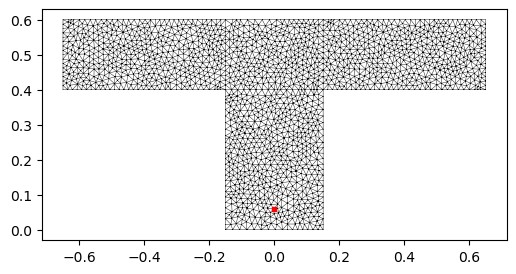

In [28]:
# define sensor locations
sensor_loc = [448]
plot_sensor(mesh, sensor_loc)

## Scenario 1: High device load (Fin overheated)

### Get sensor measurement

In [29]:
# set up hypothetical scinario that q=8
y_true, truth_solution = read_sensor(
    truth_problem=truth_problem,
    mu=mu, q_value=8, sensor_loc=sensor_loc
    )
print("sensor measurement:", y_true)

sensor measurement: [1.50885295]


### Identify current heat flux by solving inverse problem

In [30]:
stime = time.time()
mu = identify(truth_problem, sensor_loc, y_true, mu, initial_guess=1.0)
print("estimated q =", mu[2])
etime = time.time()

Identification time: 3.319199323654175
estimated q = 8.000003611518075


### Monitor temperature field based on identified heat flux
Identify the current heat flux $q$ by solving least-squares based inverse problem.

system parameters for monitoring: [2, 1, 8.000003611518075]


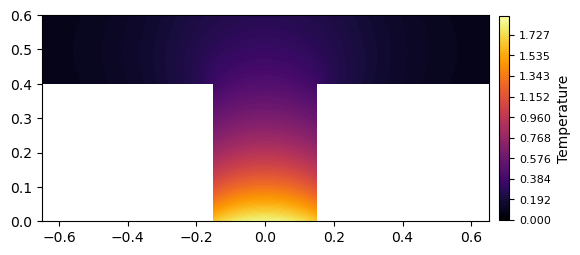

current maximum temperature: 1.8429465699611978


In [31]:
# monitor the tempearture field based on identified q
truth_solution, max_temp = monitor(
    truth_problem=truth_problem,
    mu=mu
    )

## Control cooling 
If the subfin is determined to be overheated based on the inverse identification, we increase the cooling.

In [ ]:
mu, truth_solution, max_temp, _, _ = control_cooling(
    truth_problem=truth_problem,
    current_mu=mu,
    max_temp=max_temp
)

## Scenario 2: Low device load (Fin cooled down)

In [ ]:
# get updated measurement -- the device load reduced
# set up scenario that q is reduced to 2
y_true, truth_solution = read_sensor(
    truth_problem=truth_problem,
    mu=mu, q_value=2, sensor_loc=sensor_loc
    )
print("new measurement:", y_true)

mu = identify(problem, sensor_loc, y_true, mu, initial_guess=1.0)
print("estimated q =", mu[2])

truth_solution, max_temp = monitor(
    truth_problem=truth_problem,
    mu=mu
    )

mu, truth_solution, max_temp, _, _ = control_cooling(
    truth_problem=truth_problem,
    current_mu=mu,
    max_temp=max_temp
)